# Ariel Data Challenge 2024: Quickstart

In this quickstart notebook, we show how to make predictions for the Ariel Data Challenge 2024 using only the FGS1 data.

Of course, we cross-validate our model before preparing a submission.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
from tqdm import tqdm

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error

# Reading the data

We start by reading the metadata:

In [2]:
train_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/train_adc_info.csv',
                           index_col='planet_id')
train_labels = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
                           index_col='planet_id')
test_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
                           index_col='planet_id')
sample_submission = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/sample_submission.csv',
                           index_col='planet_id')

Some facts about the data:
- We have 673 planets for training.
- There are roughly 800 planets for testing (but the test data is hidden).
- The competition is a multi-output regression task with 283 wavelengths to predict. The first one is from FGS1, the other 282 are from AIRS.

In [3]:
assert (train_adc_info.index == train_labels.index).all()
assert (test_adc_info.index == sample_submission.index).all()

## The regression target

`train_labels` contains the training targets for the regression task. There is one row per planet, and the values are the sizes of the planets. You may ask two questions now:
1. Question: What is the unit of these values? Answer: The value is the square of the radius of the planet divided by the radius of the star \\((\frac{r}{R})^2\\). As planets always are much smaller than their host stars, the values are positive but much smaller than 1.
2. Question: Why are there 283 values per row? Does the planet have 283 different sizes? Answer: We can measure the size of the planet by looking at it at different wavelengths. If the planet's atmosphere is intransparent for the specific wavelength, the planet looks slightly larger.


In [4]:
train_labels

,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,wl_274,wl_275,wl_276,wl_277,wl_278,wl_279,wl_280,wl_281,wl_282,wl_283
planet_id,,,,,,,,,,,,,,,,,,,,,
785834,0.001086,0.001137,0.001131,0.001124,0.001138,0.001131,0.001123,0.001127,0.001120,0.001116,...,0.001075,0.001076,0.001076,0.001076,0.001074,0.001073,0.001072,0.001073,0.001073,0.001072
14485303,0.001835,0.001835,0.001834,0.001833,0.001833,0.001833,0.001833,0.001834,0.001834,0.001835,...,0.001893,0.001892,0.001892,0.001891,0.001891,0.001891,0.001890,0.001890,0.001889,0.001888
17002355,0.002792,0.002814,0.002808,0.002804,0.002809,0.002805,0.002802,0.002805,0.002801,0.002797,...,0.002784,0.002783,0.002783,0.002783,0.002783,0.002784,0.002784,0.002785,0.002785,0.002784
24135240,0.001294,0.001308,0.001308,0.001306,0.001306,0.001303,0.001306,0.001314,0.001314,0.001314,...,0.001405,0.001404,0.001403,0.001402,0.001401,0.001400,0.001399,0.001397,0.001395,0.001393
25070640,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,...,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4249337798,0.000790,0.000828,0.000825,0.000822,0.000830,0.000826,0.000822,0.000823,0.000820,0.000819,...,0.000798,0.000799,0.000799,0.000799,0.000798,0.000796,0.000796,0.000796,0.000796,0.000796
4257395405,0.004063,0.004094,0.004090,0.004094,0.004083,0.004069,0.004076,0.004097,0.004100,0.004096,...,0.004042,0.004042,0.004041,0.004041,0.004041,0.004041,0.004041,0.004040,0.004040,0.004039
4266129805,0.006566,0.006569,0.006568,0.006568,0.006567,0.006567,0.006568,0.006570,0.006569,0.006568,...,0.006566,0.006566,0.006566,0.006566,0.006566,0.006566,0.006566,0.006566,0.006566,0.006566


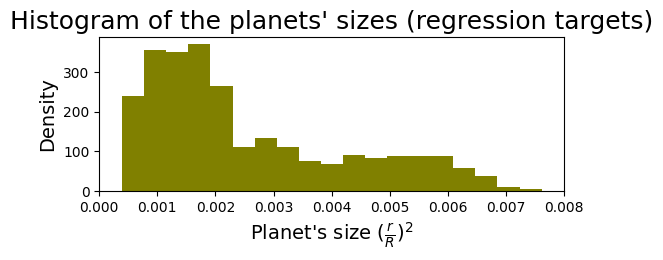

In [5]:
plt.figure(figsize=(6, 2))
plt.title("Histogram of the planets' sizes (regression targets)", fontsize=18)
plt.hist(train_labels.values.ravel(), bins=20, density=True, color='olive')
plt.xlabel(r"Planet's size $(\frac{r}{R})^2$", fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim(0, 0.008)
plt.show()

## Reading and preprocessing the FGS1 data

The FGS1 measurements consist of one file per planet (673 files for 673 planets for training). For now, we ignore the calibration files.

Each file contains 135,000 rows of images taken at 0.1 second time steps. Each row is a 32\*32 image at a single wavelength.

We read a sample file:

In [6]:
planet_id = 14485303
f_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/train/{planet_id}/FGS1_signal.parquet')
f_signal

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_1014,column_1015,column_1016,column_1017,column_1018,column_1019,column_1020,column_1021,column_1022,column_1023
0,315,313,308,301,311,315,307,298,315,320,...,304,317,304,284,321,312,314,340,297,310
1,286,325,303,309,307,332,300,299,334,319,...,306,315,304,302,312,327,318,270,299,302
2,304,292,303,318,313,308,300,316,335,356,...,329,330,305,314,302,291,314,323,315,310
3,312,300,299,347,300,317,320,319,333,350,...,316,313,310,294,319,298,310,291,287,319
4,324,313,300,334,326,312,319,305,341,317,...,294,300,313,326,334,316,293,322,310,305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134995,317,318,312,306,309,321,317,316,316,330,...,332,319,310,312,309,327,293,334,333,317
134996,312,333,321,337,311,292,315,332,315,321,...,338,298,312,317,298,304,296,280,308,297
134997,316,311,312,303,290,304,301,319,321,338,...,301,324,298,330,314,328,295,332,308,317
134998,302,309,313,306,323,315,307,320,304,340,...,308,299,324,308,321,294,312,329,315,304


Every row of the file corresponds to an image of a star:

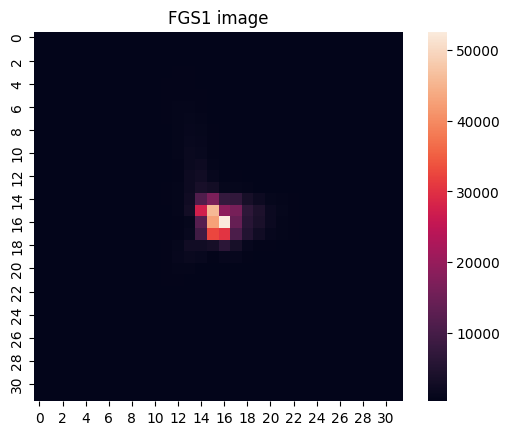

In [7]:
sns.heatmap(f_signal.iloc[1].values.reshape(32, 32))
plt.gca().set_aspect('equal')
plt.title('FGS1 image')
plt.show()

To see the so-called *light curve*, a time series, we first have to compute the difference between the even and the odd frames to get the net signal. The net signal is very noisy, and we smoothen it by computing a moving average. The plot of the smoothened signal clearly shows that the image gets darker while the planet passes in front of the star (between time steps 22000 and 45000).

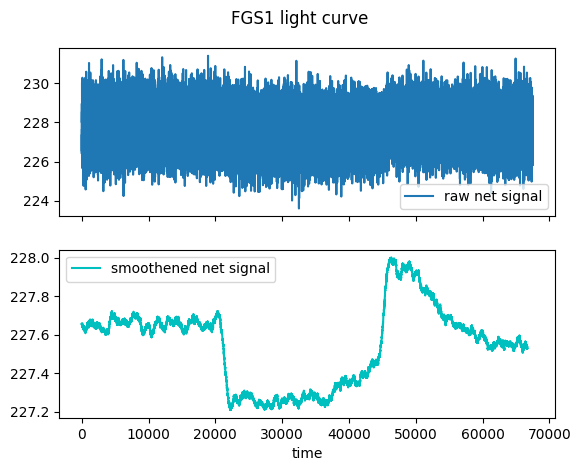

In [8]:
mean_signal = f_signal.values.mean(axis=1)
net_signal = mean_signal[1::2] - mean_signal[0::2]
cum_signal = net_signal.cumsum()
window=800
smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window

_, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(net_signal, label='raw net signal')
ax1.legend()
ax2.plot(smooth_signal, color='c', label='smoothened net signal')
ax2.legend()
ax2.set_xlabel('time')
plt.suptitle('FGS1 light curve', y=0.96)
plt.show()

We now read the FGS1 data for all 673 training planets. We keep only three values for every planet: The mean signal before, during and after the planet passes in front of the star.

In [9]:
%%time
def f_read_and_preprocess(dataset, adc_info):
    """Read the FGS1 files for all planet_ids and extract the signal.
    
    Parameters
    dataset: 'train' or 'test'
    adc_info: metadata dataframe, either train_adc_info or test_adc_info
    
    Returns
    dataframe with one row per planet_id
    
    """
    planet_ids = adc_info.index
    phases = []
    for i, planet_id in tqdm(list(enumerate(planet_ids))):
        f_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/{planet_id}/FGS1_signal.parquet')
        mean_signal = f_signal.values.mean(axis=1) # mean over the 32*32 pixels
        net_signal = mean_signal[1::2] - mean_signal[0::2]

        gain = adc_info.FGS1_adc_gain.values[i]
        step = 8000
        phases.append([net_signal[i*step:(i+1)*step].mean() * gain for i in range(len(net_signal) // step + 1)])
        
    return pd.DataFrame(phases,
                        columns=[f"phase_{i}" for i in range(len(net_signal) // step + 1)],
                        index=planet_ids)
    
train = f_read_and_preprocess('train', train_adc_info)

100%|██████████| 673/673 [16:40<00:00,  1.49s/it]

CPU times: user 14min 42s, sys: 4min 47s, total: 19min 29s
Wall time: 16min 40s


The following scatterplot shows a strong correlation between the dip in brightness when the planet is in front of the star and the planet's size.

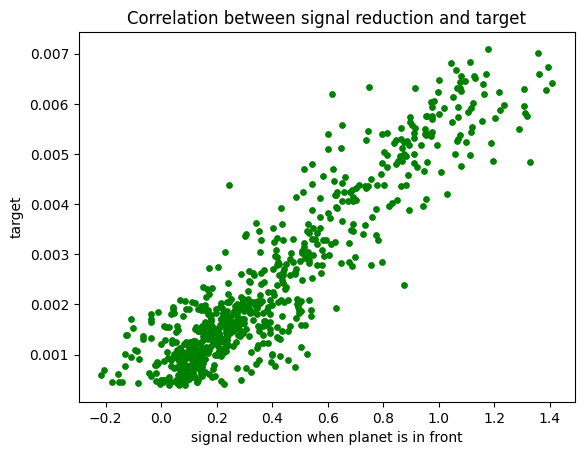

In [10]:
plt.scatter(train.iloc[:, train.shape[1] * 3 // 10] - train.iloc[:, train.shape[1] // 2], train_labels.wl_1, color='g', s=15)
plt.xlabel('signal reduction when planet is in front')
plt.ylabel('target')
plt.title('Correlation between signal reduction and target')
plt.show()

# Model and cross-validation

To keep things simple, we predict the spectra with ridge regression.

We are interested in three cross-validation metrics:
1. The R2 score is above 0.9, which confirms the correlation we've seen in the scatterplot.
2. The root mean squared error will be the predicted uncertainty.
3. The competition metric gives an indication of the leaderboard score. Unfortunately the competition metric depends on the value of `sigma_true`, which I don't know.

# R2 score: 0.952
# Root mean squared error: 0.000378


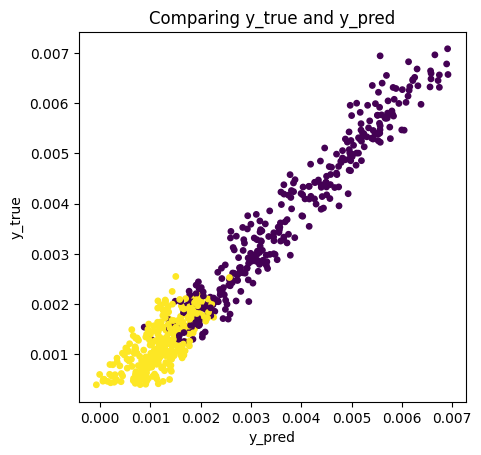

In [11]:
#####
model = RidgeCV()

oof_pred = cross_val_predict(model, train, train_labels)

print(f"# R2 score: {r2_score(train_labels, oof_pred):.3f}")
sigma_pred = mean_squared_error(train_labels, oof_pred, squared=False)
print(f"# Root mean squared error: {sigma_pred:.6f}")

col = 1
plt.scatter(oof_pred[:,col], train_labels.iloc[:,col], s=15, c=train_adc_info.star)
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred')
plt.show()

# R2 score: 0.952
# Root mean squared error: 0.000378


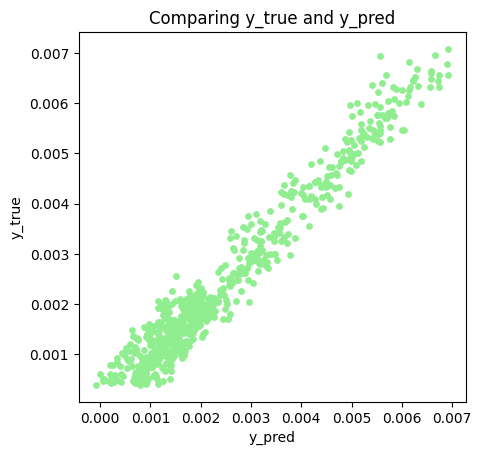

In [12]:
model = RidgeCV()

oof_pred = cross_val_predict(model, train, train_labels)

print(f"# R2 score: {r2_score(train_labels, oof_pred):.3f}")
sigma_pred = mean_squared_error(train_labels, oof_pred, squared=False)
print(f"# Root mean squared error: {sigma_pred:.6f}")

col = 1
plt.scatter(oof_pred[:,col], train_labels.iloc[:,col], s=15, c='lightgreen')
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred')
plt.show()

The following hidden cell contains the function which evaluates the competition metric.

In [13]:
# Adapted from https://www.kaggle.com/code/metric/ariel-gaussian-log-likelihood
class ParticipantVisibleError(Exception):
    pass

def competition_score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        naive_mean: float,
        naive_sigma: float,
        sigma_true: float,
        row_id_column_name='planet_id',
    ) -> float:
    '''
    This is a Gaussian Log Likelihood based metric. For a submission, which contains the predicted mean (x_hat) and variance (x_hat_std),
    we calculate the Gaussian Log-likelihood (GLL) value to the provided ground truth (x). We treat each pair of x_hat,
    x_hat_std as a 1D gaussian, meaning there will be 283 1D gaussian distributions, hence 283 values for each test spectrum,
    the GLL value for one spectrum is the sum of all of them.

    Inputs:
        - solution: Ground Truth spectra (from test set)
            - shape: (nsamples, n_wavelengths)
        - submission: Predicted spectra and errors (from participants)
            - shape: (nsamples, n_wavelengths*2)
        naive_mean: (float) mean from the train set.
        naive_sigma: (float) standard deviation from the train set.
        sigma_true: (float) essentially sets the scale of the outputs.
    '''

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if submission.min().min() < 0:
        raise ParticipantVisibleError('Negative values in the submission')
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')

    n_wavelengths = len(solution.columns)
    if len(submission.columns) != n_wavelengths*2:
        raise ParticipantVisibleError('Wrong number of columns in the submission')

    y_pred = submission.iloc[:, :n_wavelengths].values
    # Set a non-zero minimum sigma pred to prevent division by zero errors.
    sigma_pred = np.clip(submission.iloc[:, n_wavelengths:].values, a_min=10**-15, a_max=None)
    y_true = solution.values

    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true * np.ones_like(y_true)))
    GLL_mean = np.sum(scipy.stats.norm.logpdf(y_true, loc=naive_mean * np.ones_like(y_true), scale=naive_sigma * np.ones_like(y_true)))

    submit_score = (GLL_pred - GLL_mean)/(GLL_true - GLL_mean)
    return float(np.clip(submit_score, 0.0, 1.0))

In [14]:
def make_dataframe(pred_array, index, sigma_pred):
    """Create a submission dataframe from predictions and uncertainty"""
    return pd.concat([pd.DataFrame(pred_array.clip(train_labels.values.min(), train_labels.values.max()), 
                                   index=index,
                                   columns=train_labels.columns),
                      pd.DataFrame(sigma_pred,
                                   index=index,
                                   columns=[f"sigma_{i}" for i in range(1, 284)])],
                     axis=1)

oof_df = make_dataframe(oof_pred, train_adc_info.index, sigma_pred)
display(oof_df)

gll_score = competition_score(train_labels.copy().reset_index(),
                              oof_df.copy().reset_index(),
                              naive_mean=train_labels.values.mean(),
                              naive_sigma=train_labels.values.std(),
                              sigma_true=0.00001)
print(f"# Estimated competition score: {gll_score:.3f}")


,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
planet_id,,,,,,,,,,,,,,,,,,,,,
785834,0.001210,0.001225,0.001228,0.001229,0.001231,0.001231,0.001231,0.001232,0.001233,0.001234,...,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378
14485303,0.001823,0.001842,0.001841,0.001838,0.001842,0.001840,0.001838,0.001840,0.001839,0.001839,...,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378
17002355,0.003234,0.003273,0.003262,0.003254,0.003256,0.003243,0.003242,0.003256,0.003251,0.003244,...,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378
24135240,0.001134,0.001158,0.001157,0.001155,0.001159,0.001155,0.001154,0.001157,0.001156,0.001155,...,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378
25070640,0.002194,0.002243,0.002229,0.002219,0.002222,0.002207,0.002205,0.002222,0.002216,0.002207,...,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4249337798,0.001125,0.001156,0.001152,0.001148,0.001150,0.001143,0.001143,0.001152,0.001150,0.001146,...,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378
4257395405,0.004041,0.004074,0.004064,0.004059,0.004058,0.004046,0.004047,0.004061,0.004058,0.004051,...,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378
4266129805,0.006913,0.006919,0.006916,0.006914,0.006912,0.006909,0.006910,0.006915,0.006914,0.006912,...,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378


# Estimated competition score: 0.270


In [15]:
# Refit the model to the full dataset
model.fit(train, train_labels)

# Predict
test = f_read_and_preprocess('test', test_adc_info)
test_pred = model.predict(test)

# Package into submission file
sub = make_dataframe(test_pred, test_adc_info.index, sigma_pred)
display(sub)
#sub.to_csv('submission.csv')
#!head submission.csv

100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
planet_id,,,,,,,,,,,,,,,,,,,,,
499191466,0.002645,0.002666,0.002667,0.002666,0.002669,0.002667,0.002667,0.00267,0.002669,0.00267,...,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378


# Outlook: The AIRS measurements

AIRS is the other sensor of the satellite. Again, it produces one file per planet.

Each file contains 11,250 rows of images captured at constant time steps. Each 32 x 356 image has been flattened into 11392 columns.

In [16]:
a_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/train/{planet_id}/AIRS-CH0_signal.parquet')
a_signal

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_11382,column_11383,column_11384,column_11385,column_11386,column_11387,column_11388,column_11389,column_11390,column_11391
0,673,669,685,665,702,682,691,683,670,698,...,673,682,671,676,697,674,687,683,668,674
1,693,691,691,704,680,687,697,693,675,689,...,699,678,700,693,696,693,691,673,688,690
2,695,688,680,699,689,669,711,709,672,674,...,668,685,702,681,688,705,671,686,686,682
3,688,709,688,692,691,711,704,694,700,693,...,683,705,701,697,696,704,711,685,694,713
4,679,681,676,705,710,684,665,688,700,684,...,673,681,687,692,672,663,690,675,694,706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245,671,683,679,699,701,694,697,677,709,679,...,700,675,673,708,686,687,705,704,706,693
11246,673,685,707,681,698,686,698,685,701,696,...,692,704,686,682,681,684,683,687,680,689
11247,684,686,699,675,687,710,680,701,671,687,...,701,710,687,707,688,692,689,681,695,693
11248,683,699,674,679,664,690,680,683,674,695,...,689,692,685,687,678,684,690,682,691,677


In [17]:
a_signal = a_signal.values.reshape(11250, 32, 356)

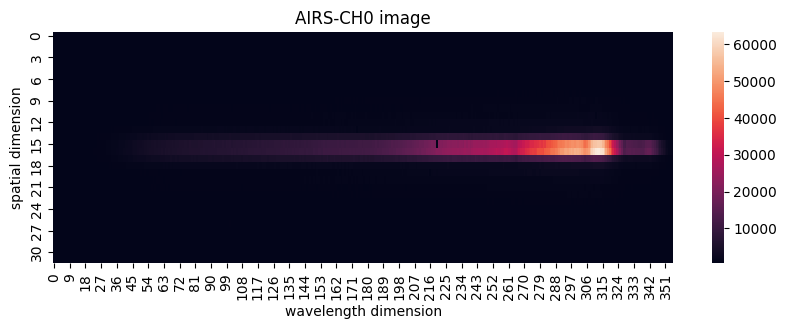

In [18]:
plt.figure(figsize=(10, 3))
plt.title('AIRS-CH0 image')
sns.heatmap(a_signal[1])
plt.ylabel('spatial dimension')
plt.xlabel('wavelength dimension')
plt.show()

The data again is a time series, and we can see the star being obscured while the planet is passing in front of it.

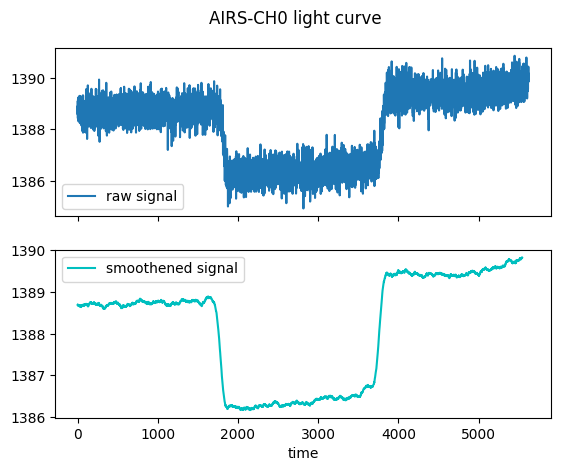

In [19]:
mean_signal = a_signal.mean(axis=2).mean(axis=1)
net_signal = mean_signal[1::2] - mean_signal[0::2]
cum_signal = net_signal.cumsum()
window=80
smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window

_, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(net_signal, label='raw signal')
ax1.legend()
ax2.plot(smooth_signal, color='c', label='smoothened signal')
ax2.legend()
ax2.set_xlabel('time')
plt.suptitle('AIRS-CH0 light curve', y=0.96)
plt.show()
